In [1]:
#Install libraries
install.packages("keras")
install.packages("dplyr")
install.packages("ggplot2")
install.packages("purrr")
install.packages("caret")
install.packages("SnowballC")
install.packages("ggplot2")
install.packages("tm")
install.packages("wordcloud")
install.packages('e1071')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘plyr’, ‘ModelMetrics’, ‘reshape2’, ‘recipes’, ‘pROC’




In [3]:
#load the libraries
library(keras)
library(dplyr)
library(ggplot2)
library(purrr)
library(caret)
library(SnowballC)
library(ggplot2)
library(tm)
library(wordcloud)
library(knitr)
library(e1071)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [6]:
# Read data
df <- readr::read_csv('cleaned_anon.csv')
# head(df)

Rows: 4199 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): decision, narrative, title
dbl (3): submitted, id, requested


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [7]:
#take only required columns
df2 = df[,c(3,4)]

# head(df2)

In [8]:
#distribution of decision
df2 %>% count(decision)

decision,n
<chr>,<int>
Proceed,189
Turndown,4010


In [19]:
#find out what is the distribution of the number of words when decision is Proceed
df2[df2$decision == 'Proceed',]$narrative %>%
  strsplit(" ") %>%
  sapply(length) %>% 
  summary()

  #find out what is the distribution of the number of words when decision is Turndown
df2[df2$decision == 'Turndown',]$narrative %>%
  strsplit(" ") %>%
  sapply(length) %>% 
  summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    240    1028    1075    1033    1101    1219 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   46.0   933.0  1056.0   963.4  1103.0  1455.0 

In [9]:
post = Corpus(VectorSource(df2$narrative)) # creating corpus

In [10]:
post = tm_map(post, removeNumbers) #removing numbers from narratives

Warning message in tm_map.SimpleCorpus(post, removeNumbers):
“transformation drops documents”


In [11]:
post = tm_map(post, removePunctuation) #removing punctuations from narratives

Warning message in tm_map.SimpleCorpus(post, removePunctuation):
“transformation drops documents”


In [12]:
post = tm_map(post, stripWhitespace) #removing unnecessary whitespaces from narratives

Warning message in tm_map.SimpleCorpus(post, stripWhitespace):
“transformation drops documents”


In [13]:
post <- tm_map(post,content_transformer(tolower)) #lowercasing text

Warning message in tm_map.SimpleCorpus(post, content_transformer(tolower)):
“transformation drops documents”


In [14]:
post <- tm_map(post, removeWords, stopwords("english")) #removing frequently occuring words like - the,it,is

Warning message in tm_map.SimpleCorpus(post, removeWords, stopwords("english")):
“transformation drops documents”


In [15]:
post <- tm_map(post,stemDocument) #normaling words into its root form using stemming technique

Warning message in tm_map.SimpleCorpus(post, stemDocument):
“transformation drops documents”


In [20]:
#convert the corpus into dataframe
post_df = data.frame(text = sapply(post, as.character), stringsAsFactors = FALSE)

In [21]:
#add target column i.e. decision column
post_df$decision = df2$decision

In [ ]:
# check few rows after series of transformation done above
head(post_df,2)

text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Approach 1: Using Neural Network

In [23]:
#train test split
set.seed(123)
train.index <- createDataPartition(post_df$decision, p = .75, list = FALSE)
train <- post_df[ train.index,]
test  <- post_df[-train.index,]

In [24]:
#find out what is the distribution of the number of words in each review
post_df$text %>%
  strsplit(" ") %>%
  # strsplit(gsub("[^[:alnum:] ]", "", str), " +") %>%
  sapply(length) %>% 
  summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   23.0   569.0   660.0   596.4   687.0   906.0 

In [25]:
#define our Text Vectorization layer, it will be responsible to take the string input and convert it to a Tensor
num_words <- 12000
max_length <- 700
text_vectorization <- layer_text_vectorization(
  max_tokens = num_words, 
  output_sequence_length = max_length, 
  # output_mode = 'tf-idf',
  # ngrams = 2,
  # split = "whitespace"
)

In [26]:
#Apply on our text
text_vectorization %>% 
  adapt(post_df$text)

In [59]:
#define our neural network in terms of keras layers
input <- layer_input(shape = c(1), dtype = "string")

output <- input %>% 
  text_vectorization() %>% 
  layer_embedding(input_dim = num_words + 1, output_dim = 256) %>%
  layer_global_average_pooling_1d() %>%
  # bidirectional(layer_lstm(units = 128)) %>%
  # layer_dropout(0.5) %>%
  # layer_dense(units = 1024, activation = "relu") %>%
  # layer_dropout(0.5) %>%
  layer_dense(units = 256, activation = "relu") %>%
  layer_dropout(0.5) %>%
  layer_dense(units = 128, activation = "relu") %>%
  layer_dropout(0.5) %>%
  layer_dense(units = 1, activation = "sigmoid")

In [60]:
#create model
model <- keras_model(input, output)

In [61]:
#compile model by defining optimizer, loss function and evaluation metric
model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = list('AUC')
)

In [62]:
# start the run
history <- model %>% fit(
  train$text,
  as.numeric(train$decision == "Proceed"),
  epochs = 3,
  batch_size = 32,
  class_weight = list('1':5.,'0':95.),
  validation_split = 0.2,
  verbose=2
)

In [63]:
#evaluate model on test dataset
results <- model %>% evaluate(test$text, as.numeric(test$decision == "Proceed"), verbose = 0)
results

loss       auc 
0.1784566 0.8183951

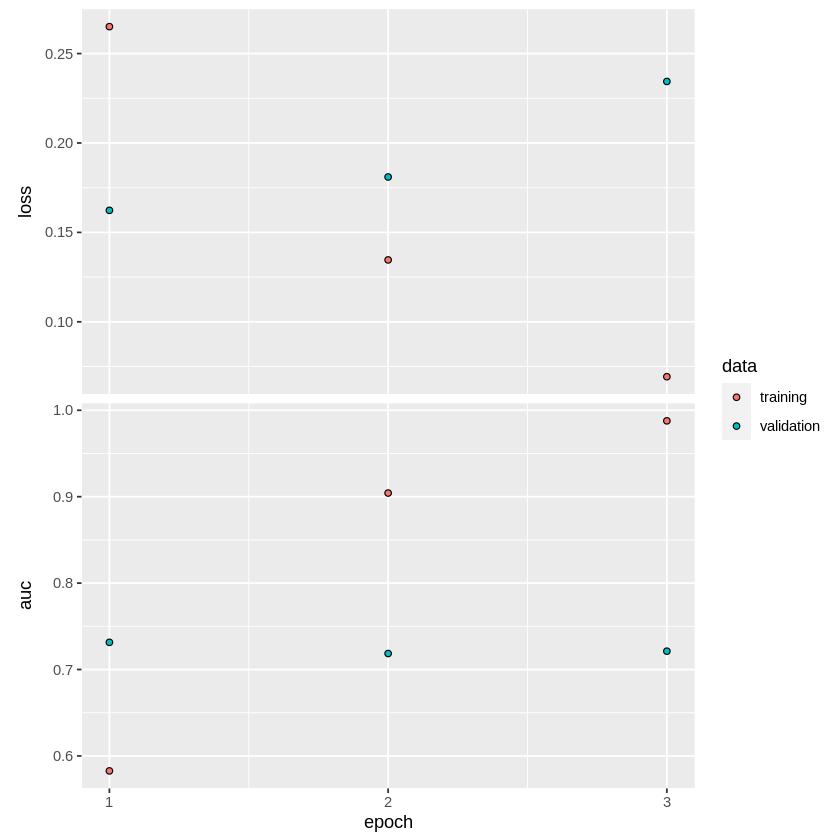

In [64]:
# plot how the loss and AUC metric component on each epoch
plot(history)

In [65]:
#predict on our test set
preds <- model %>% predict_on_batch(test$text)

In [66]:
# convert the decision test set into factors
y_test = as.factor(test$decision)
levels(y_test) = c(1,0)

In [67]:
#for each of the different threshold on model prediction, print the confusion matrix
#Note : Model will predict the decision in terms of probability value (between 0 and 1)
for (t in c(0.4,0.45,0.5,0.55,0.6))
{
  pred2 = as.numeric(preds > t)
  pred2 = as.factor(pred2)
  print(table(y_test,pred2))
}

      pred2
y_test   0   1
     1  40   7
     0 999   3
      pred2
y_test    0    1
     1   41    6
     0 1000    2
      pred2
y_test    0    1
     1   43    4
     0 1001    1
      pred2
y_test    0
     1   47
     0 1002
      pred2
y_test    0
     1   47
     0 1002


In [68]:
# Choose the one which gives best result
pred2 = as.numeric(preds > 0.4)
pred2 = as.factor(pred2)

In [69]:
#print the confusion matrix
table(y_test,pred2)

      pred2
y_test   0   1
     1  40   7
     0 999   3

In [72]:
# print the confusion matrix with detailed report
confusionMatrix(y_test,pred2, dnn = c("Proceed", "Turndown"))

Warning message in confusionMatrix.default(y_test, pred2, dnn = c("Proceed", "Turndown")):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

       Turndown
Proceed   0   1
      0 999   3
      1  40   7
                                          
               Accuracy : 0.959           
                 95% CI : (0.9452, 0.9702)
    No Information Rate : 0.9905          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2336          
                                          
 Mcnemar's Test P-Value : 4.021e-08       
                                          
            Sensitivity : 0.9615          
            Specificity : 0.7000          
         Pos Pred Value : 0.9970          
         Neg Pred Value : 0.1489          
             Prevalence : 0.9905          
         Detection Rate : 0.9523          
   Detection Prevalence : 0.9552          
      Balanced Accuracy : 0.8308          
                                          
       'Positive' Class : 0               
                                          

Approach 2: Using Document Term Matrix and Classifier

In [73]:
# coerces post into a Document Term Matrix
dtm <- DocumentTermMatrix(post)

In [74]:
dtm

<<DocumentTermMatrix (documents: 4199, terms: 110587)>>
Non-/sparse entries: 1304583/463050230
Sparsity           : 100%
Maximal term length: 837
Weighting          : term frequency (tf)

In [75]:
# Sum all columns(words) to get frequency
words_frequency <- colSums(as.matrix(dtm)) 

In [76]:
# verify that the terms are still equal to dtm
length(words_frequency)

[1] 110587

In [77]:
# create sort order (descending) for matrix
ord <- order(words_frequency, decreasing=TRUE)

In [78]:
# get the top 10 words by frequency of appearance
words_frequency[head(ord, 10)] %>% 
  kable()



|          |     x|
|:---------|-----:|
|health    | 45884|
|will      | 44901|
|communiti | 21023|
|provid    | 16622|
|care      | 16522|
|program   | 16054|
|project   | 15726|
|patient   | 13127|
|use       | 12927|
|can       | 11623|

In [127]:
  # convert our "clean" corpus into a tfidf weighted dtm
removeSparseTerms(DocumentTermMatrix(post, control = list(weighting = weightTfIdf)),0.88) -> dtm_tfidf

Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom functions are ignored”


In [128]:
# View details of tfidf weighted dtm
dtm_tfidf

<<DocumentTermMatrix (documents: 4199, terms: 629)>>
Non-/sparse entries: 717299/1923872
Sparsity           : 73%
Maximal term length: 12
Weighting          : term frequency - inverse document frequency (normalized) (tf-idf)

In [129]:
dtm_tfidf_df = as.data.frame(as.matrix(dtm_tfidf), stringsAsFactors=False)

dtm_tfidf_df$target_decision = df2$decision

In [130]:
#train test split
set.seed(123)
train.index <- createDataPartition(dtm_tfidf_df$target_decision, p = .75, list = FALSE)
train <- dtm_tfidf_df[ train.index,]
test  <- dtm_tfidf_df[-train.index,]

In [101]:
install.packages('abind')
install.packages('zoo')
install.packages('xts')
install.packages('quantmod')
install.packages('ROCR')
install.packages('randomForest')
install.packages('gbm')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘TTR’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘DMwR’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


In [155]:
#download folder from -> https://cran.r-project.org/src/contrib/Archive/DMwR/DMwR_0.4.1.tar.gz
#once downloaded run below command to install. Ensure the path is correct where the folder is kept

# install.packages( "/content/DMwR_0.4.1.tar.gz", repos=NULL, type="source" )

In [109]:
library(e1071)
library(randomForest)
library(gbm)
library(DMwR)
library(pROC) # for AUC calculations

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [ ]:
trControl <- trainControl(method = 'cv',
                          number = 5)

model_CV <- train(target_decision~., 
                  data = train,
                  method = 'rf',
                  trControl = trControl)

In [133]:
# Set up control function for training
ctrl <- trainControl(method = "repeatedcv",
                     number = 5,
                     repeats = 3,
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE)

In [156]:
# Build smote model (Smote is used for class balance)
ctrl$sampling <- "smote"
smote_fit <- train(target_decision ~ .,
                   data = train,
                   method = "gbm",
                   verbose = FALSE,
                   metric = "ROC",
                   trControl = ctrl)

In [141]:
# Build custom AUC function to extract AUC
# from the caret model object
test_roc <- function(model, data) {
  
  roc(data$target_decision,
      predict(model, data, type = "prob")[, "Proceed"])
}


In [142]:
# Print AUC score
smote_fit %>%
  test_roc(data = test) %>%
  auc()

Setting levels: control = Proceed, case = Turndown

Setting direction: controls > cases



Area under the curve: 0.7976

In [144]:
# fetch prediction in form of class and probabilities
class <- predict(smote_fit, test)
probs <- predict(smote_fit, test,'prob')

In [145]:
#print confusion matrix
table(as.factor(test$target_decision),class)

          class
           Proceed Turndown
  Proceed       34       13
  Turndown     245      757

In [139]:
#print detailed confusion matrix report
confusionMatrix(as.factor(test$target_decision),class)

Confusion Matrix and Statistics

          Reference
Prediction Proceed Turndown
  Proceed       21       26
  Turndown      82      920
                                         
               Accuracy : 0.897          
                 95% CI : (0.877, 0.9148)
    No Information Rate : 0.9018         
    P-Value [Acc > NIR] : 0.719          
                                         
                  Kappa : 0.2328         
                                         
 Mcnemar's Test P-Value : 1.207e-07      
                                         
            Sensitivity : 0.20388        
            Specificity : 0.97252        
         Pos Pred Value : 0.44681        
         Neg Pred Value : 0.91816        
             Prevalence : 0.09819        
         Detection Rate : 0.02002        
   Detection Prevalence : 0.04480        
      Balanced Accuracy : 0.58820        
                                         
       'Positive' Class : Proceed        
                       